# Análisis de Texto de Noticias

En este notebook se realiza un análisis exploratorio detallado de los textos de noticias, incluyendo distribuciones de longitud, palabras más frecuentes, n-gramas y correlaciones entre términos.

Importar todas las librerías necesarias

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar stopwords si no están disponibles
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
except:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

Definir directorios y cargar datos procesados y resumidos

In [2]:
# Usa el directorio actual del notebook como raíz del proyecto
ROOT_DIR = Path.cwd().parent

# Define las rutas a los directorios de datos
PROCESSED_DIR = ROOT_DIR / "data" / "news" / "processed"
SUMMARIES_DIR = ROOT_DIR / "data" / "news" / "summarized"

# Cargar todos los archivos de noticias procesadas
processed_files = list(PROCESSED_DIR.glob("*.parquet"))
df_processed = pd.concat(
    [pd.read_parquet(file) for file in processed_files],
    ignore_index=True
)

# Cargar todos los archivos de noticias resumidas
summarized_files = list(SUMMARIES_DIR.glob("*.parquet"))
df_summarized = pd.concat(
    [pd.read_parquet(file) for file in summarized_files],
    ignore_index=True
)

print(f"Noticias procesadas cargadas: {len(df_processed)} registros")
print(f"Noticias resumidas cargadas: {len(df_summarized)} registros")
print(f"\nColumnas en df_processed: {list(df_processed.columns)}")
print(f"Columnas en df_summarized: {list(df_summarized.columns)}")

Noticias procesadas cargadas: 118655 registros
Noticias resumidas cargadas: 115405 registros

Columnas en df_processed: ['id', 'author', 'created', 'title', 'teaser', 'clean_body']
Columnas en df_summarized: ['id', 'author', 'created', 'title', 'teaser', 'clean_body', 'body_summary']


## Análisis de Valores Nulos

Analizar presencia de valores nulos en las columnas textuales del dataset procesado

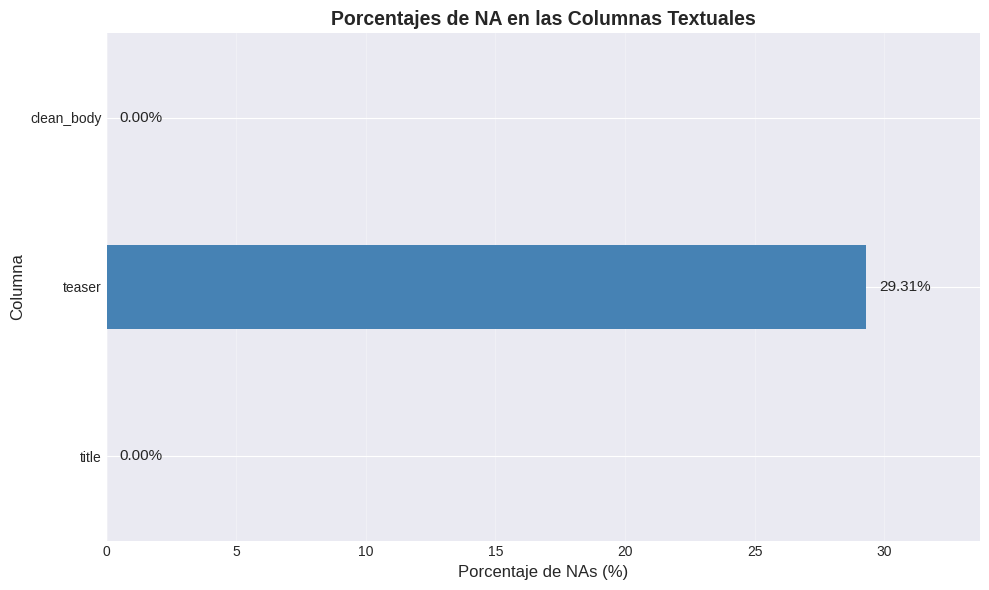


Resumen de valores nulos:
Total de filas: 118,655
title: 1 (0.00%)
teaser: 34,772 (29.31%)
clean_body: 0 (0.00%)


In [3]:
# Contar valores nulos en columnas textuales
textual_columns = ['title', 'teaser', 'clean_body']
total_rows = len(df_processed)
na_counts = df_processed[textual_columns].isna().sum()
na_percentages = (na_counts / total_rows) * 100

# Crear gráfico de barras horizontales
fig, ax = plt.subplots(figsize=(10, 6))
na_percentages.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Porcentaje de NAs (%)', fontsize=12)
ax.set_ylabel('Columna', fontsize=12)
ax.set_title('Porcentajes de NA en las Columnas Textuales', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Ajustar límite del eje x para acomodar etiquetas
max_value = na_percentages.max()
ax.set_xlim(0, max_value * 1.15)

# Añadir etiquetas de valor en las barras
for i, v in enumerate(na_percentages):
    ax.text(v + 0.5, i, f'{v:.2f}%', va='center', fontsize=11)

plt.tight_layout()
plt.show()

print("\nResumen de valores nulos:")
print(f"Total de filas: {total_rows:,}")
for col in textual_columns:
    print(f"{col}: {na_counts[col]:,} ({na_percentages[col]:.2f}%)")

## Preparación de Datos para Análisis

Preparar dataset de noticias resumidas para análisis de texto, concatenando título y resumen

In [4]:
# Trabajar con el dataset de noticias resumidas
df = df_summarized.copy()

# Concatenar título y resumen del cuerpo
df["text"] = df["title"] + "\n\n" + df["body_summary"]

# Eliminar filas con valores nulos en la columna de texto
df = df.dropna(subset=["text"]).copy()
df['text'] = df['text'].astype(str)

print(f"Usando columna de texto: 'text'")
print(f"Número total de textos válidos: {len(df):,}")
print(f"Columnas disponibles: {list(df.columns)}")

Usando columna de texto: 'text'
Número total de textos válidos: 115,404
Columnas disponibles: ['id', 'author', 'created', 'title', 'teaser', 'clean_body', 'body_summary', 'text']


## Distribución de Palabras Más Frecuentes

Extraer y contar todas las palabras del corpus, excluyendo stopwords

In [5]:
# Extraer todas las palabras
all_words = []
all_words_with_stopwords = []

for text in df['text']:
    words = re.findall(r'\b[a-zA-Z]{2,}\b', str(text).lower())
    all_words_with_stopwords.extend(words)
    # Filtrar stopwords
    words_filtered = [word for word in words if word not in STOPWORDS and len(word) > 2]
    all_words.extend(words_filtered)

# Contar palabras
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

print(f"Total de palabras únicas (sin stopwords): {len(word_counts):,}")
print(f"Total de palabras procesadas (sin stopwords): {len(all_words):,}")
print(f"Total de palabras con stopwords: {len(all_words_with_stopwords):,}")
print(f"Stopwords eliminadas: {len(all_words_with_stopwords) - len(all_words):,} ({(len(all_words_with_stopwords) - len(all_words))/len(all_words_with_stopwords)*100:.1f}%)")

Total de palabras únicas (sin stopwords): 67,208
Total de palabras procesadas (sin stopwords): 5,866,863
Total de palabras con stopwords: 8,978,220
Stopwords eliminadas: 3,111,357 (34.7%)


Visualizar las 20 palabras más frecuentes

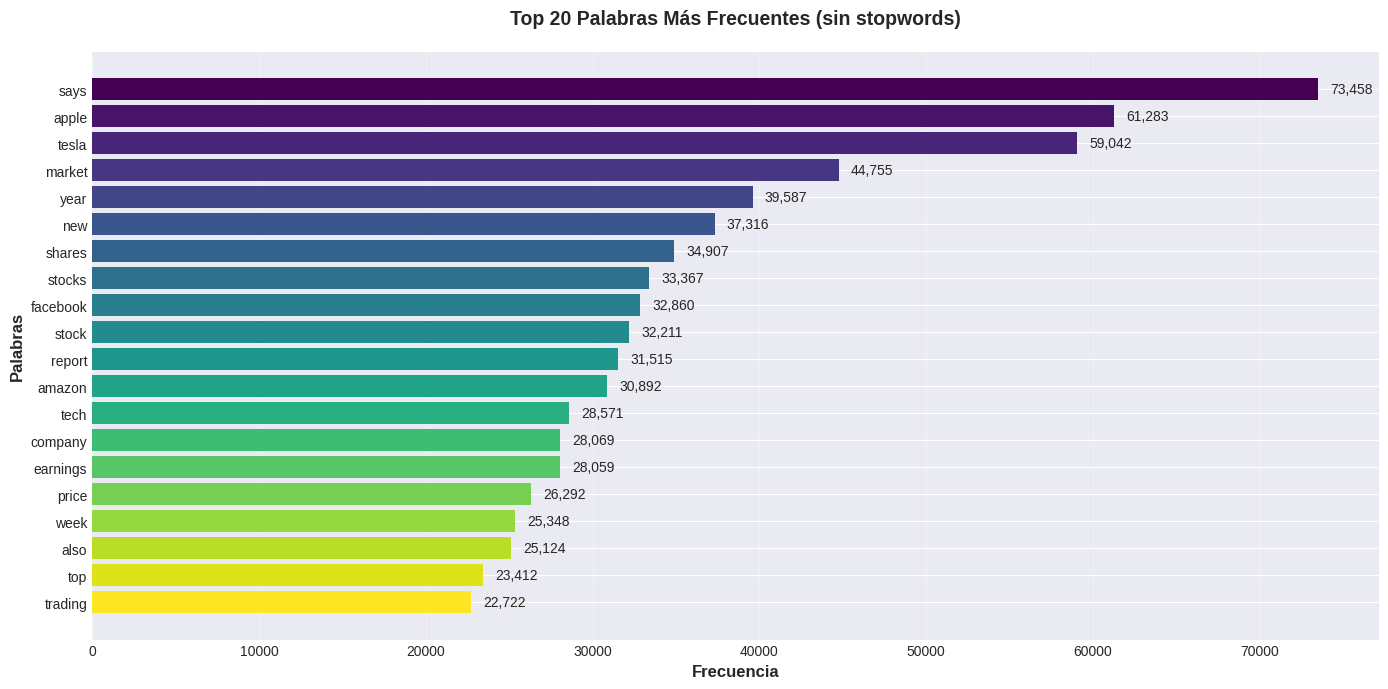

In [6]:
# Gráfico de barras de las 20 palabras más comunes
fig, ax = plt.subplots(figsize=(14, 7))
words, counts = zip(*most_common)
bars = ax.barh(range(len(words)), counts, color=plt.cm.viridis(np.linspace(0, 1, len(words))))
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_ylabel('Palabras', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Palabras Más Frecuentes (sin stopwords)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (word, count) in enumerate(most_common):
    ax.text(count + max(counts)*0.01, i, f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Nube de Palabras

Generar nube de palabras con los términos más frecuentes

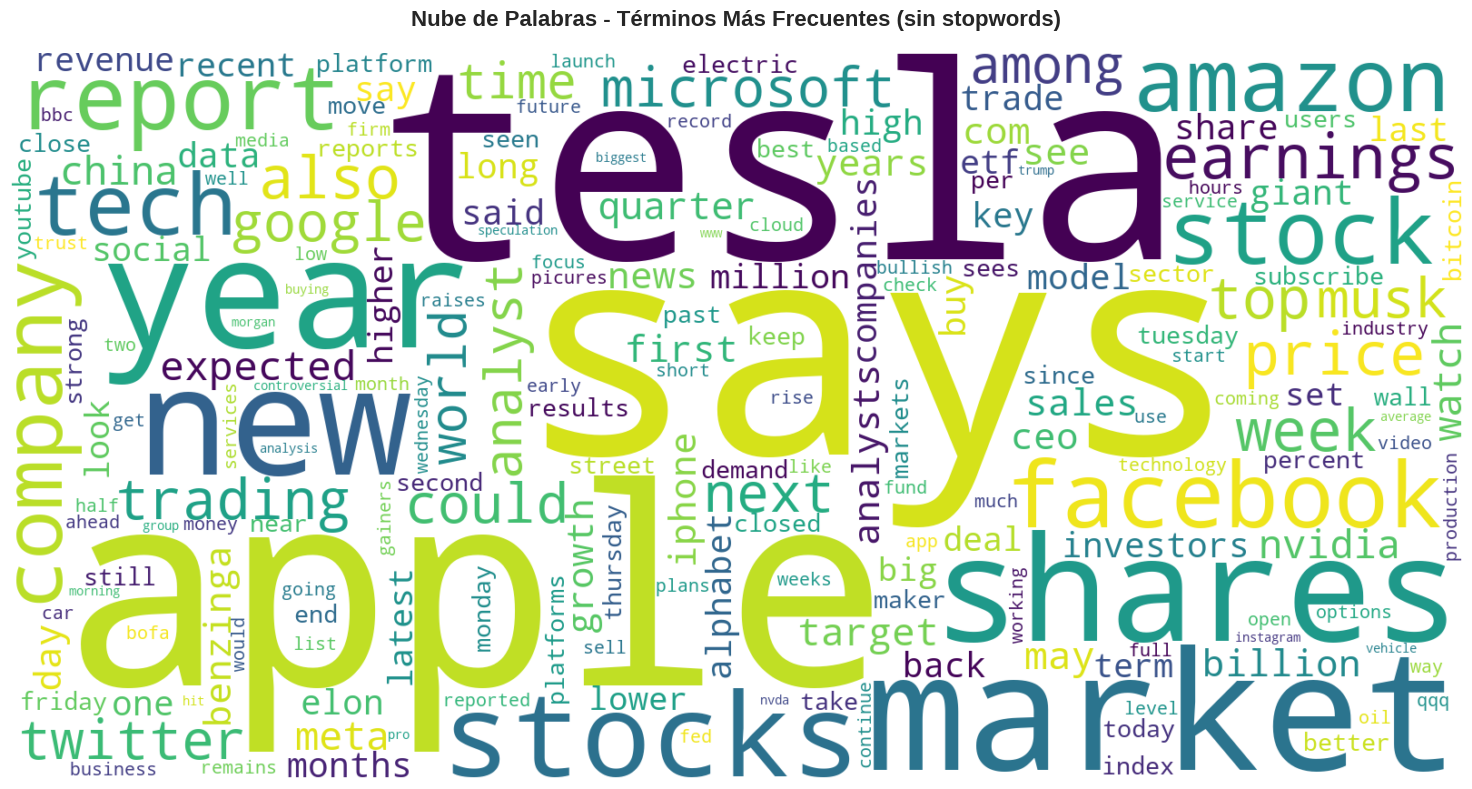

In [7]:
# Nube de palabras (sin stopwords)
fig, ax = plt.subplots(figsize=(16, 8))
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10,
    stopwords=STOPWORDS,
    collocations=False
).generate_from_frequencies(word_counts)

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Nube de Palabras - Términos Más Frecuentes (sin stopwords)', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Análisis de Longitud de Textos

Calcular longitud en caracteres y palabras de cada texto

In [8]:
# Calcular longitudes
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print("ESTADÍSTICAS DE LONGITUD DE TEXTOS")
print("="*50)
print("\nCaracteres:")
print(df['char_length'].describe())
print("\nPalabras:")
print(df['word_count'].describe())

ESTADÍSTICAS DE LONGITUD DE TEXTOS

Caracteres:
count    115404.000000
mean        495.892135
std         166.547948
min         213.000000
25%         410.000000
50%         446.000000
75%         498.000000
max        2146.000000
Name: char_length, dtype: float64

Palabras:
count    115404.000000
mean         81.257296
std          27.234793
min          19.000000
25%          67.000000
50%          74.000000
75%          82.000000
max         350.000000
Name: word_count, dtype: float64


Visualizar distribuciones de longitud mediante histogramas y boxplots

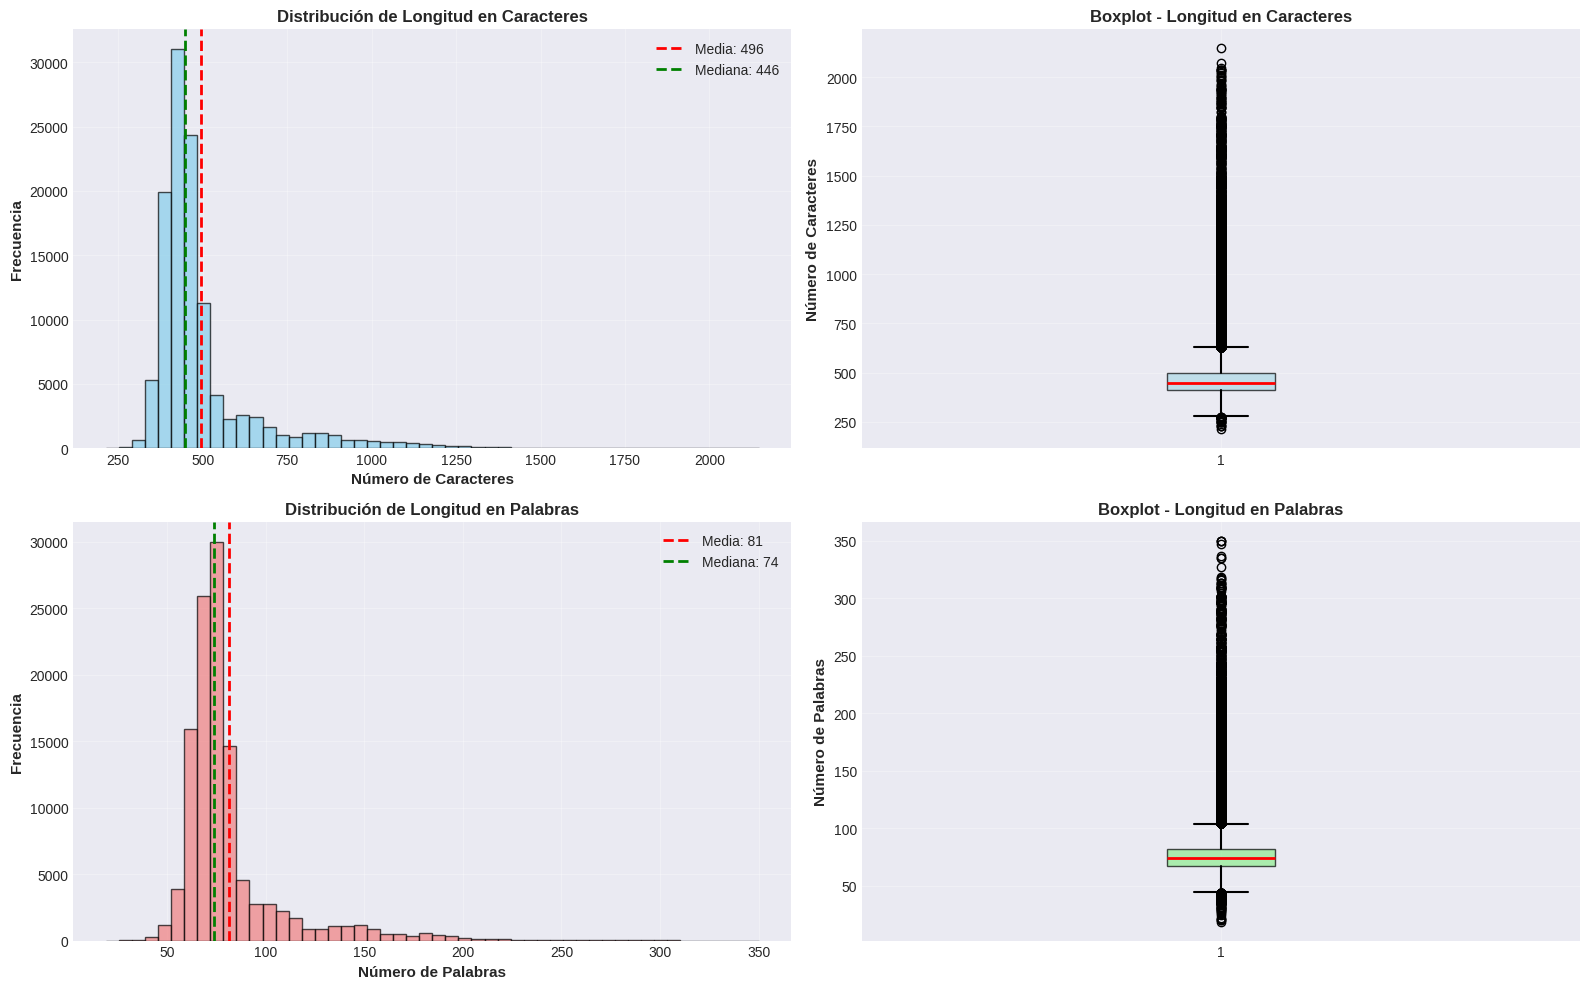

In [9]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograma - Caracteres
axes[0, 0].hist(df['char_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['char_length'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {df["char_length"].mean():.0f}')
axes[0, 0].axvline(df['char_length'].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {df["char_length"].median():.0f}')
axes[0, 0].set_xlabel('Número de Caracteres', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribución de Longitud en Caracteres', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot - Caracteres
axes[0, 1].boxplot(df['char_length'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
axes[0, 1].set_ylabel('Número de Caracteres', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Boxplot - Longitud en Caracteres', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Histograma - Palabras
axes[1, 0].hist(df['word_count'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {df["word_count"].mean():.0f}')
axes[1, 0].axvline(df['word_count'].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {df["word_count"].median():.0f}')
axes[1, 0].set_xlabel('Número de Palabras', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribución de Longitud en Palabras', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Boxplot - Palabras
axes[1, 1].boxplot(df['word_count'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
axes[1, 1].set_ylabel('Número de Palabras', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Boxplot - Longitud en Palabras', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Análisis de N-gramas

Definir función para extraer n-gramas de los textos

In [10]:
def get_ngrams(text, n, remove_stopwords=True):
    """
    Extraer n-gramas de un texto.
    """
    words = re.findall(r'\b[a-zA-Z]{2,}\b', str(text).lower())
    
    if remove_stopwords:
        words = [word for word in words if word not in STOPWORDS and len(word) > 2]
    
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

Extraer bi-gramas y tri-gramas del corpus

In [11]:
# Extraer bi-gramas y tri-gramas (sin stopwords)
bigrams = []
trigrams = []

for text in df['text']:
    bigrams.extend(get_ngrams(text, 2, remove_stopwords=True))
    trigrams.extend(get_ngrams(text, 3, remove_stopwords=True))

# Contar n-gramas
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

top_bigrams = bigram_counts.most_common(20)
top_trigrams = trigram_counts.most_common(20)

print(f"Total de bi-gramas únicos (sin stopwords): {len(bigram_counts):,}")
print(f"Total de tri-gramas únicos (sin stopwords): {len(trigram_counts):,}")

Total de bi-gramas únicos (sin stopwords): 1,399,630
Total de tri-gramas únicos (sin stopwords): 2,767,331


Visualizar los n-gramas más frecuentes

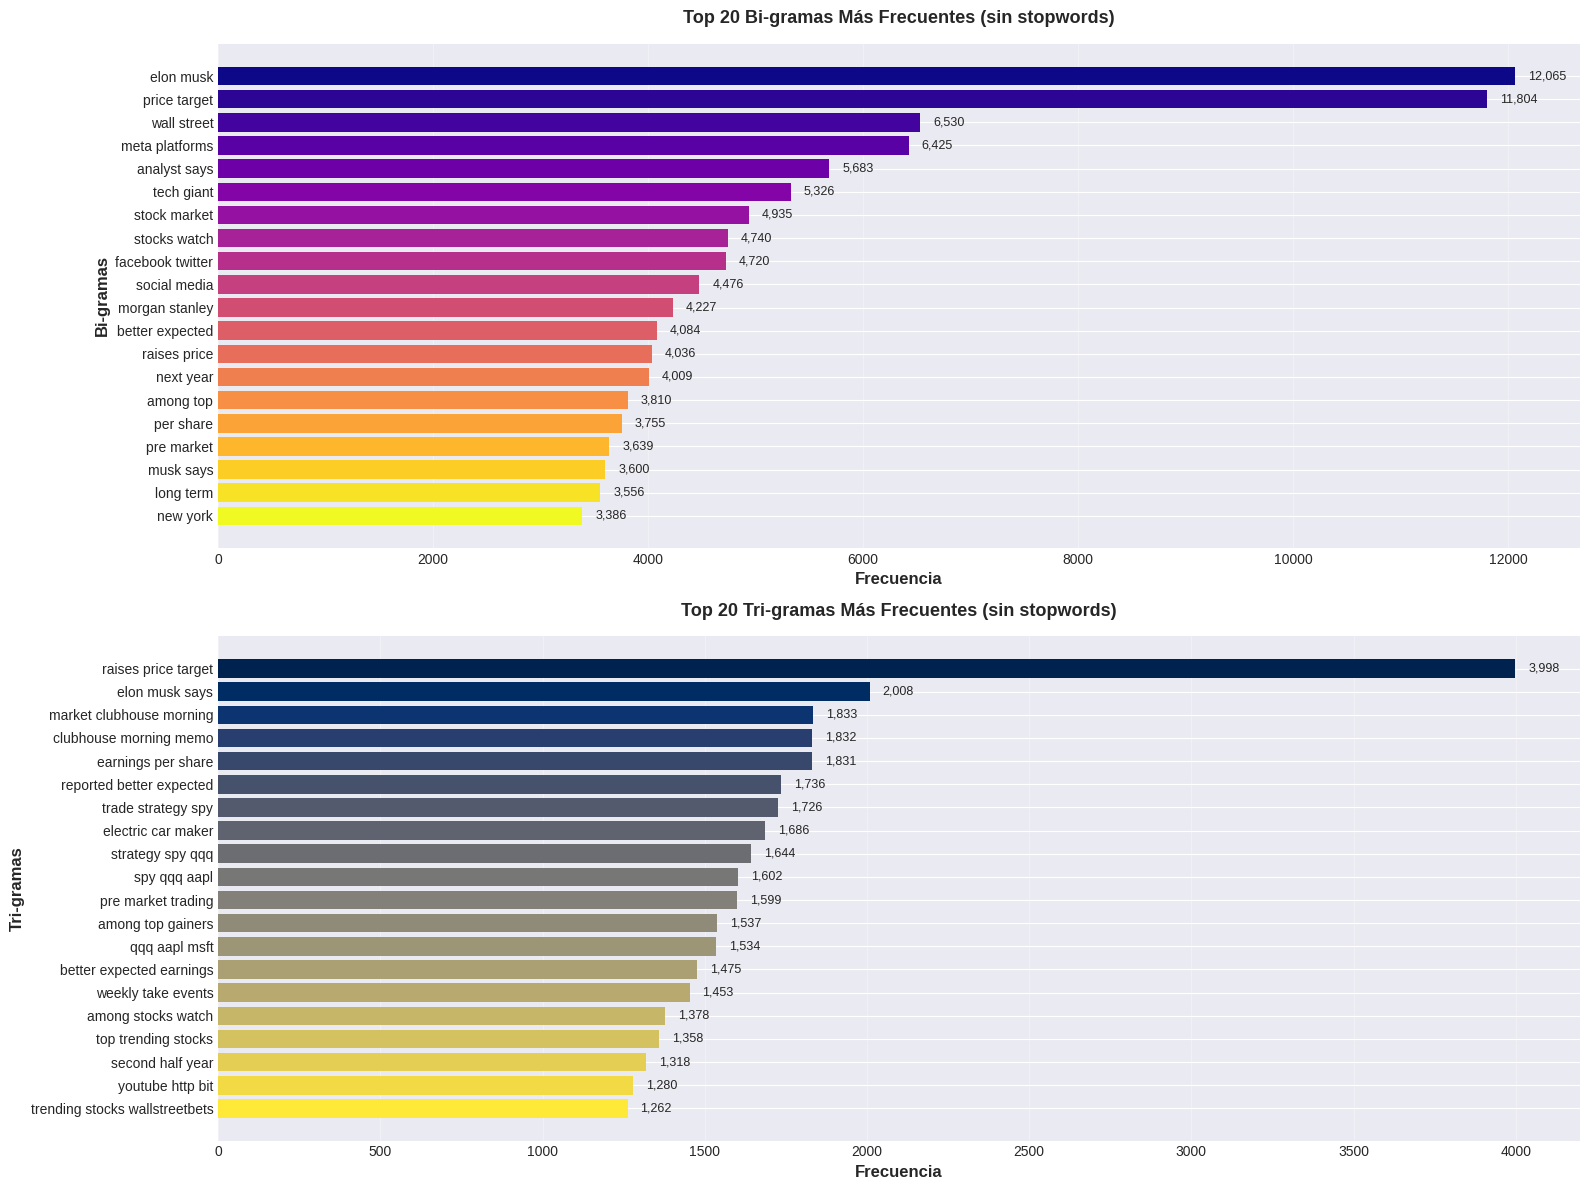

In [12]:
# Visualización de n-gramas
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Bi-gramas
if top_bigrams:
    bigram_words, bigram_cnts = zip(*top_bigrams)
    axes[0].barh(range(len(bigram_words)), bigram_cnts, 
                 color=plt.cm.plasma(np.linspace(0, 1, len(bigram_words))))
    axes[0].set_yticks(range(len(bigram_words)))
    axes[0].set_yticklabels(bigram_words, fontsize=10)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Bi-gramas', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 20 Bi-gramas Más Frecuentes (sin stopwords)', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(axis='x', alpha=0.3)
    
    for i, (word, count) in enumerate(top_bigrams):
        axes[0].text(count + max(bigram_cnts)*0.01, i, f'{count:,}', 
                    va='center', fontsize=9)

# Tri-gramas
if top_trigrams:
    trigram_words, trigram_cnts = zip(*top_trigrams)
    axes[1].barh(range(len(trigram_words)), trigram_cnts, 
                 color=plt.cm.cividis(np.linspace(0, 1, len(trigram_words))))
    axes[1].set_yticks(range(len(trigram_words)))
    axes[1].set_yticklabels(trigram_words, fontsize=10)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Tri-gramas', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 20 Tri-gramas Más Frecuentes (sin stopwords)', 
                      fontsize=13, fontweight='bold', pad=15)
    axes[1].grid(axis='x', alpha=0.3)
    
    for i, (word, count) in enumerate(top_trigrams):
        axes[1].text(count + max(trigram_cnts)*0.01, i, f'{count:,}', 
                    va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Análisis de Correlaciones entre Palabras

Crear matriz TF-IDF y calcular correlaciones entre términos

In [13]:
# Crear matriz TF-IDF (usando un subset si el dataset es muy grande)
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

print(f"Creando matriz TF-IDF con {sample_size} documentos...")

vectorizer = TfidfVectorizer(
    max_features=100,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 1)
)

tfidf_matrix = vectorizer.fit_transform(df_sample['text'])
feature_names = vectorizer.get_feature_names_out()

print(f"Matriz TF-IDF creada: {tfidf_matrix.shape}")

# Matriz de correlación entre palabras
correlation_matrix = np.corrcoef(tfidf_matrix.toarray().T)

# Seleccionar top 30 palabras más frecuentes para el heatmap
top_n = min(30, len(feature_names))
top_indices = np.argsort(np.array(tfidf_matrix.sum(axis=0)).flatten())[-top_n:]
top_features = [feature_names[i] for i in top_indices]
top_corr = correlation_matrix[np.ix_(top_indices, top_indices)]

print(f"\nGenerando heatmap con top {top_n} palabras...")

Creando matriz TF-IDF con 5000 documentos...
Matriz TF-IDF creada: (5000, 100)

Generando heatmap con top 30 palabras...


Visualizar heatmap de correlaciones entre términos

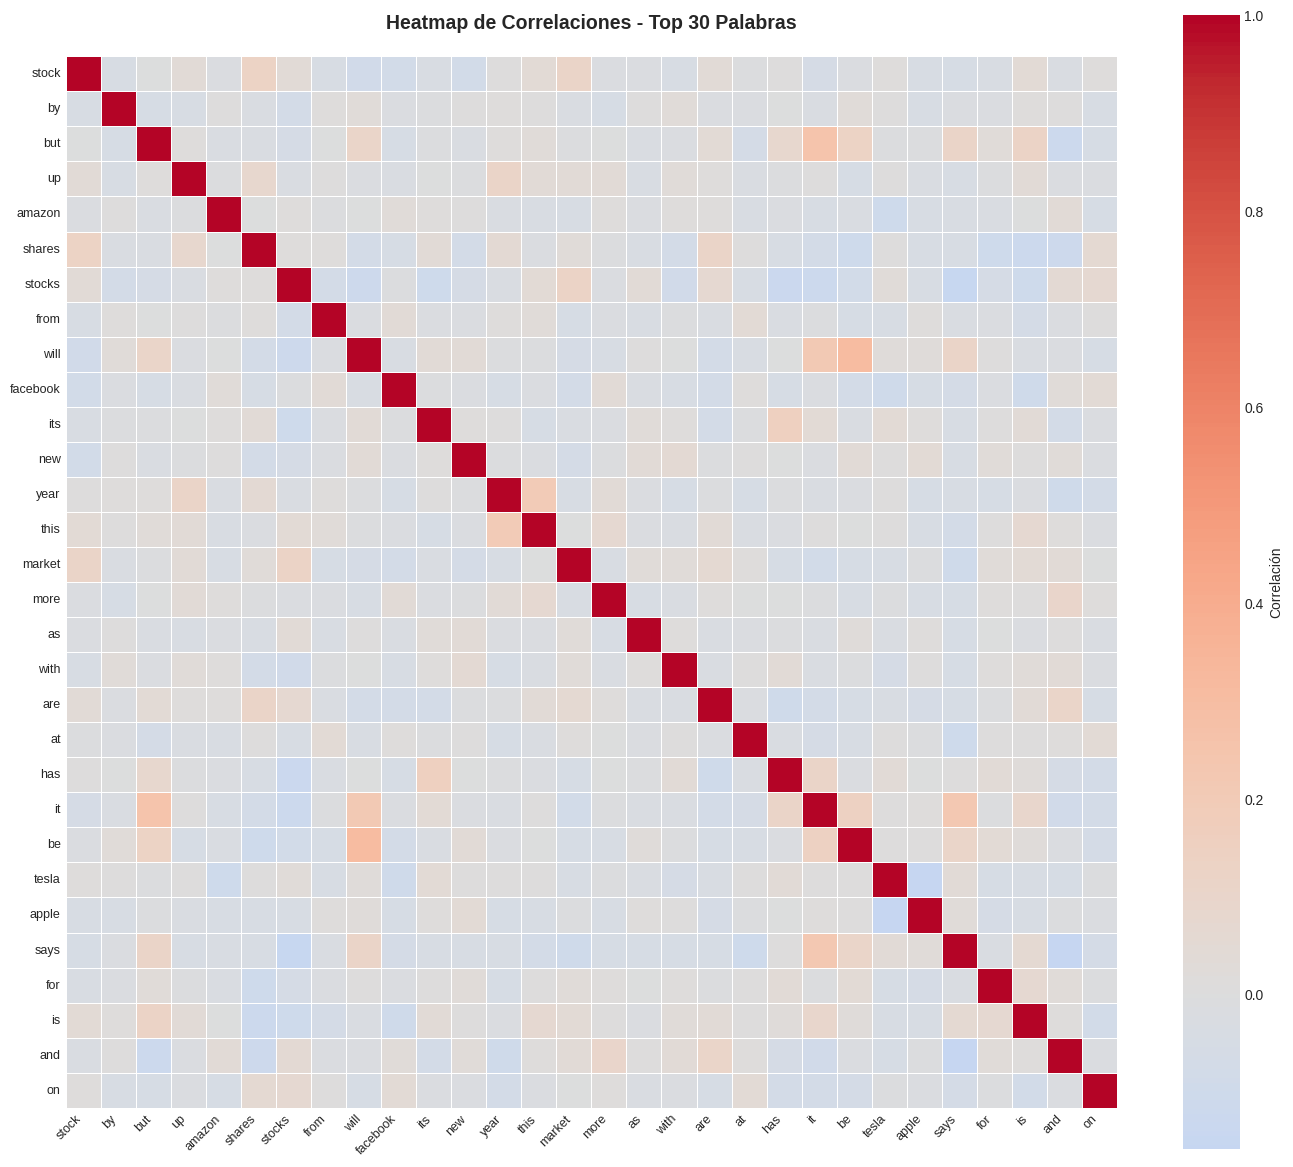

In [14]:
# Heatmap de correlaciones
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(top_corr, 
            xticklabels=top_features, 
            yticklabels=top_features,
            cmap='coolwarm', 
            center=0,
            annot=False,
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlación'})
ax.set_title(f'Heatmap de Correlaciones - Top {top_n} Palabras', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()